In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Transform
transform = transforms.Compose([
    transforms.ToTensor()
])

# MNIST Dataset
train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


Using device: cuda


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.08MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.73MB/s]


TASK -----------------------------------------2

In [3]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(28*28, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

        # Decoder
        self.fc2 = nn.Linear(latent_dim, 400)
        self.fc3 = nn.Linear(400, 28*28)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


tgask -------3

In [4]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(
        recon_x, x, reduction='sum'
    )

    kl_loss = -0.5 * torch.sum(
        1 + logvar - mu.pow(2) - logvar.exp()
    )

    return recon_loss + kl_loss


task ---4


In [5]:
model = VAE(latent_dim=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 20
train_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for data, _ in train_loader:
        data = data.view(-1, 28*28).to(device)

        optimizer.zero_grad()
        recon, mu, logvar = model(data)
        loss = vae_loss(recon, data, mu, logvar)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f}")


Epoch [1/20] Loss: 190.3273
Epoch [2/20] Loss: 168.7489
Epoch [3/20] Loss: 164.3716
Epoch [4/20] Loss: 161.7082
Epoch [5/20] Loss: 159.8346
Epoch [6/20] Loss: 158.3200
Epoch [7/20] Loss: 157.1333
Epoch [8/20] Loss: 156.1186
Epoch [9/20] Loss: 155.2908
Epoch [10/20] Loss: 154.6225
Epoch [11/20] Loss: 153.9194
Epoch [12/20] Loss: 153.3586
Epoch [13/20] Loss: 152.8872
Epoch [14/20] Loss: 152.3857
Epoch [15/20] Loss: 151.9859
Epoch [16/20] Loss: 151.6169
Epoch [17/20] Loss: 151.2535
Epoch [18/20] Loss: 150.8868
Epoch [19/20] Loss: 150.5885
Epoch [20/20] Loss: 150.3036


task ---5

In [6]:
def generate_samples(model, num_samples=16):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, 2).to(device)
        samples = model.decode(z)
        samples = samples.view(-1, 28, 28).cpu()

    return samples


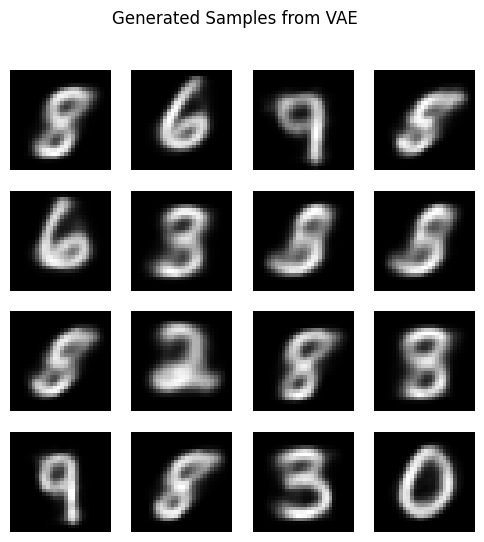

In [7]:
samples = generate_samples(model)

plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(samples[i], cmap="gray")
    plt.axis("off")
plt.suptitle("Generated Samples from VAE")
plt.show()


task ---6

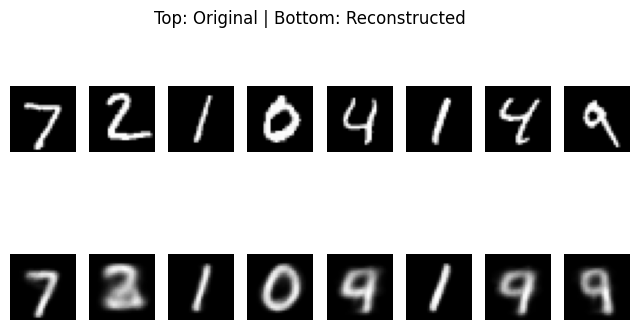

In [8]:
model.eval()
data, _ = next(iter(test_loader))
data = data.view(-1, 28*28).to(device)

with torch.no_grad():
    recon, _, _ = model(data)

plt.figure(figsize=(8,4))
for i in range(8):
    # Original
    plt.subplot(2,8,i+1)
    plt.imshow(data[i].view(28,28).cpu(), cmap="gray")
    plt.axis("off")

    # Reconstructed
    plt.subplot(2,8,i+9)
    plt.imshow(recon[i].view(28,28).cpu(), cmap="gray")
    plt.axis("off")

plt.suptitle("Top: Original | Bottom: Reconstructed")
plt.show()
